## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a buyers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

In [ ]:
num_features_to_select = 5
latitude_condition = True

In [175]:
df = pd.read_csv('data/cleaned_data.csv')
df.drop(['id','date','Unnamed: 0','yr_renovated','sqft_living15'],axis=1,inplace=True)
df = df[df['yr_built'] > 1930]
df.reset_index(drop=True,inplace=True)
if latitude_condition:
    df = df[df['lat']< df['lat'].mean()]

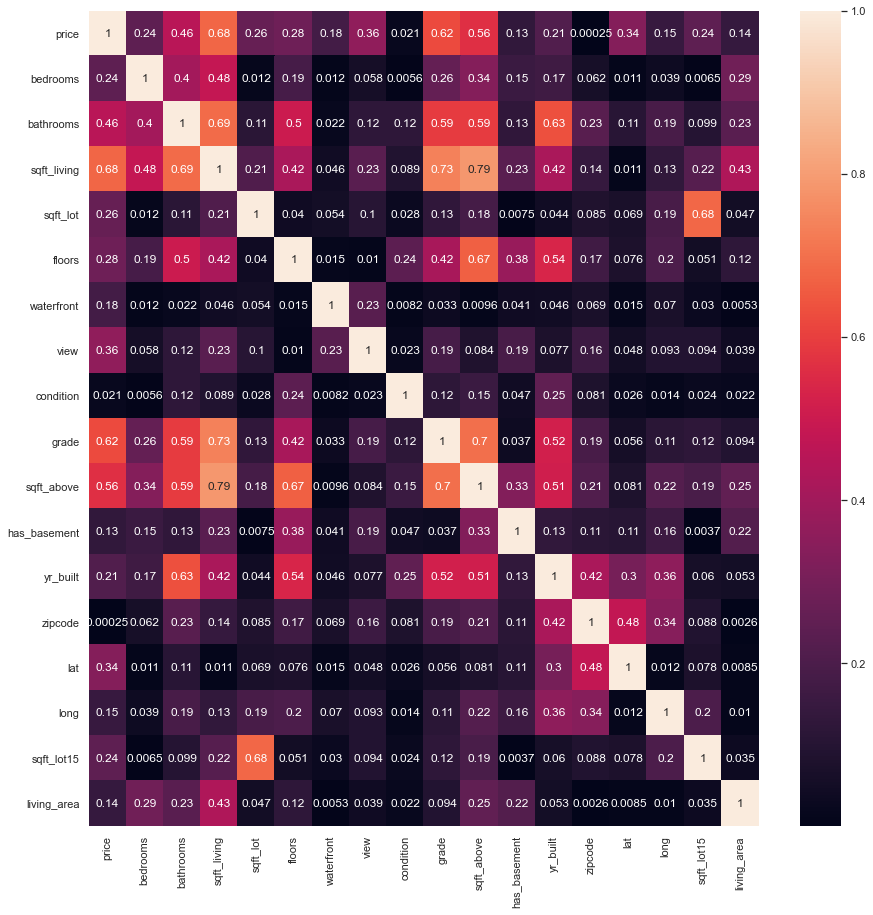

In [176]:
sns.set(rc={'figure.figsize':(15, 15)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(df.corr().abs(),annot=True);

In [177]:
df_base = pd.read_csv('data/kc_house_data.csv')
df_base.drop(['id','date','yr_renovated'],axis=1,inplace=True)
df_base_corrs = df_base.corr()['price'].map(abs).sort_values(ascending=False)
df_base_corrs

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
zipcode          0.053402
long             0.022036
Name: price, dtype: float64

In [178]:
df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs

price           1.000000
sqft_living     0.679009
grade           0.622103
sqft_above      0.563087
bathrooms       0.455855
view            0.361928
lat             0.336008
floors          0.281888
sqft_lot        0.263931
sqft_lot15      0.244017
bedrooms        0.242763
yr_built        0.212309
waterfront      0.177090
long            0.148133
living_area     0.140979
has_basement    0.132951
condition       0.020650
zipcode         0.000255
Name: price, dtype: float64

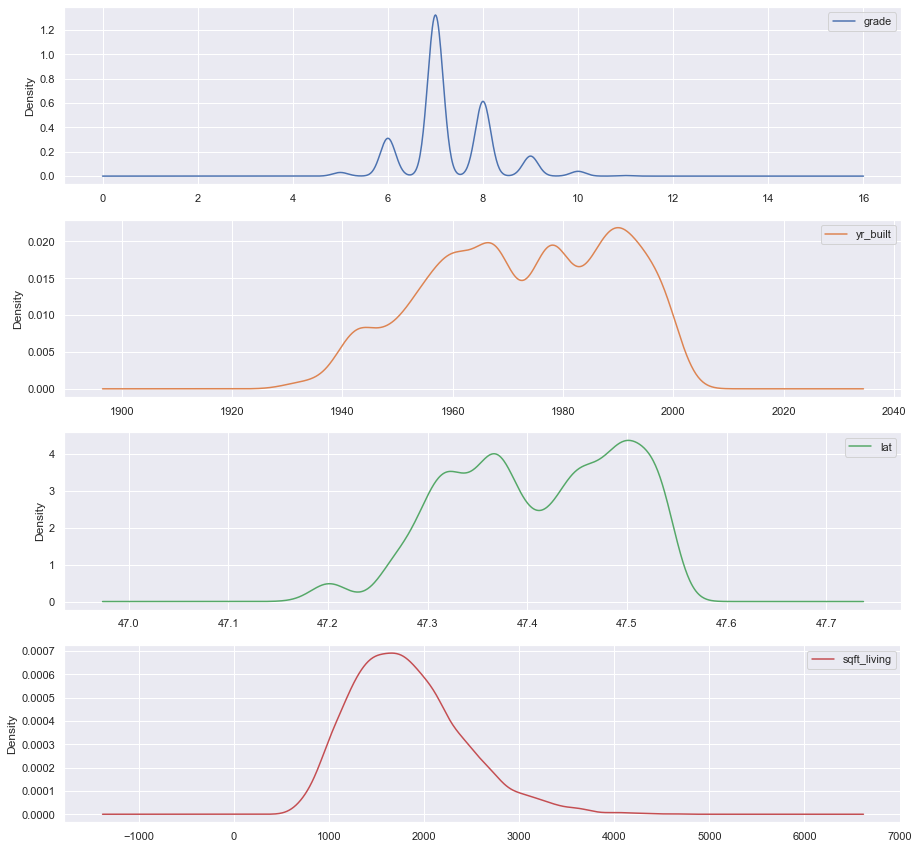

In [179]:
df.filter(['grade','yr_built','lat','sqft_living'],axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

<AxesSubplot:>

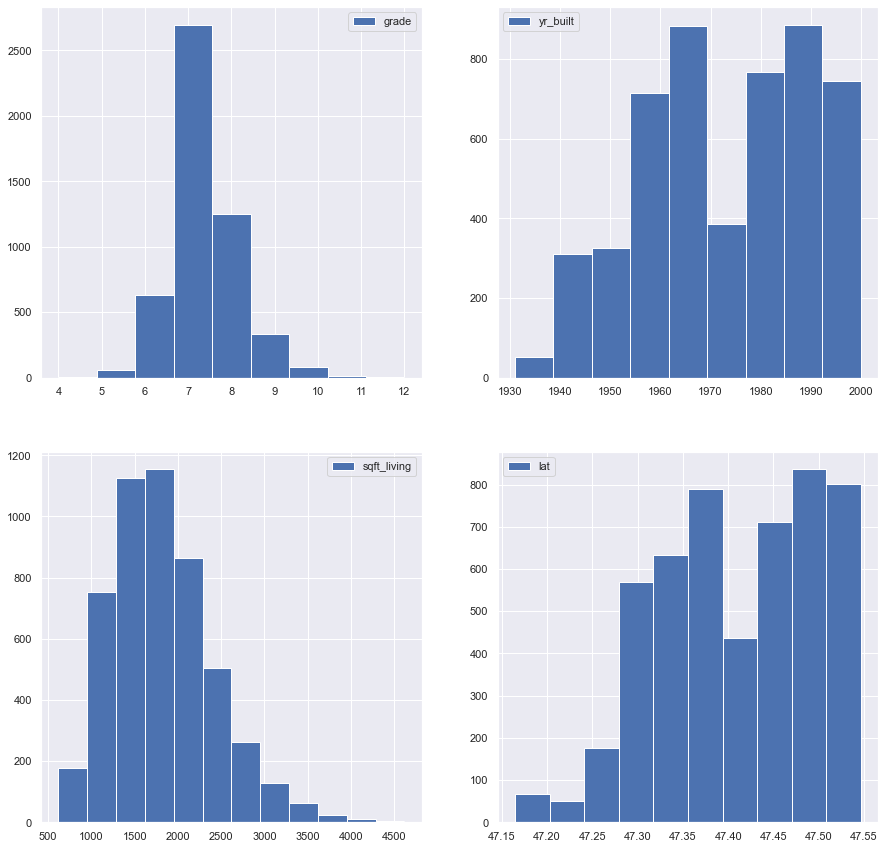

In [180]:
fig,axes = plt.subplots(nrows=2,ncols=2)

df['grade'].hist(bins=9,ax=axes[0,0],legend=True)
df['yr_built'].hist(bins=9,ax=axes[0,1],legend=True)
df['sqft_living'].hist(bins=12,ax=axes[1,0],legend=True)
df['lat'].hist(bins=10,ax=axes[1,1],legend=True)

In [181]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

In [182]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [188]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]

In [189]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

In [190]:
# Baseline Model
baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

333048.58456607495

In [191]:
formula = f'price ~ {keep_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     1961.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:53:03   Log-Likelihood:                -51737.
No. Observations:                4056   AIC:                         1.035e+05
Df Residuals:                    4051   BIC:                         1.035e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     3.33e+05   1317.384    252.811      0.000     3.3e+05    3.36e+05
sqft_living  6.087e+04   1995.684     30.503      0.000     5.7e+04    6.48e+04
view         2.807e+04   1358.406     20.667      0.000    2.54e+04    3.07e+04
grade        4.163e+04   1977.502     21.053      0.000    3.78e+04    4.55e+04
lat          4.968e+04   1323.367     37.537      0.000    4.71e+04    5.23e+04
==============================================================================
Omnibus:                     1119.329   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4879.026
Skew:                           1.280   Prob(JB):                         0.00
Kurtosis:                       7.725   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     452.4
Date:                Mon, 04 Oct 2021   Prob (F-statistic):          2.67e-223
Time:                        13:53:03   Log-Likelihood:                -12908.
No. Observations:                1014   AIC:                         2.583e+04
Df Residuals:                    1009   BIC:                         2.585e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.332e+05   2585.631    128.867      0.000    3.28e+05    3.38e+05
sqft_living  5.923e+04   3871.617     15.300      0.000    5.16e+04    6.68e+04
view         2.512e+04   2779.430      9.037      0.000    1.97e+04    3.06e+04
grade         4.82e+04   3830.931     12.583      0.000    4.07e+04    5.57e+04
lat          4.941e+04   2623.172     18.835      0.000    4.43e+04    5.46e+04
==============================================================================
Omnibus:                      433.358   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2879.151
Skew:                           1.832   Prob(JB):                         0.00
Kurtosis:                      10.398   Cond. No.                         2.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""